In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fresnel Propagation using FFT

Fourier transform을 사용하여 Fresnel propagation을 시뮬레이션

In [ ]:
# parameter
mm = 1e-3
um = mm*mm
nm = um*mm
wvl = 635 * nm  # Red
k = (2 * np.pi) / wvl

# size
pp = 3.5 * um # SLM pixel pitch
sizeX = 0.01
ph = wvl / sizeX  # hologram plane pixel pitch
h = 1080
w = 1920

# point coordinate
x0 = 0
y0 = 0.05
z0 = 0

def fft(f):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(f)))

def ifft(f):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(f)))

# Impulse response
Impulse response 와 u(x0,y0)의 곱을 푸리에 트렌스폼을 취함  
point의 좌표에 따라서 kernel을 모두 만들어놓고 fft를 진행

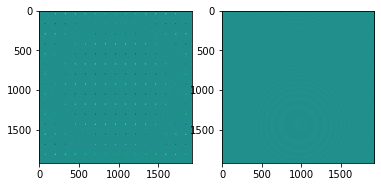

In [ ]:
zz = 0.8
def Frsn_kernel(x1, y1, z1, p):
    '''
    프레넬 커널을 만들고, 7.51 s 걸림
    '''
    a = np.zeros((w, w), dtype='complex128')
    for i in range(w):
        for j in range(w):
            x = x1 + (j - w/2) * p
            y = y1 + (i - w/2) * p
            z = z1 + zz
            a[i, j] = np.exp(1j * k * (x**2 + y**2) / (2 * z))
    return a

h_fr = Frsn_kernel(x0, y0, z0, ph)
H = fft(h_fr)

plt.subplot(121)
plt.imshow(np.real(h_fr))

plt.subplot(122)
plt.imshow(np.real(H))

In [ ]:
%timeit Frsn_kernel(x0, y0, z0, ph)

1 loop, best of 3: 7.51 s per loop


(1080, 1920)


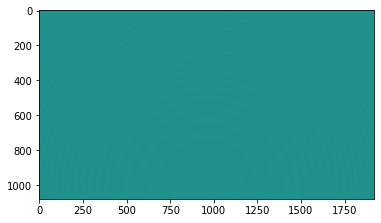

In [ ]:
# crop H
H_crop = H[(w-h)//2 : (w+h)//2 , :]
print(H_crop.shape)
plt.imshow(np.imag(H_crop))

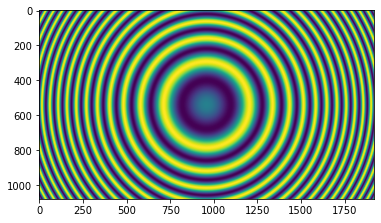

In [ ]:
amp = Frsn_kernel(0,0,0, pp) * (np.exp(1j*k*zz) / (1j * wvl * zz))
amp = amp[(w-h)//2 : (w+h)//2,:]
plt.imshow(np.real(amp))

Text(0.5, 1.0, 'imag part')

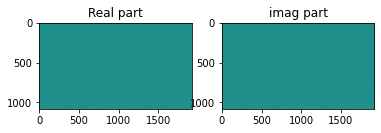

In [ ]:
# Complex image
ch = amp * H_crop

plt.subplot(121)
plt.imshow(np.real(ch))
plt.title('Real part')

plt.subplot(122)
plt.imshow(np.imag(ch))
plt.title('imag part')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plyfile
import multiprocessing

# parameters
mm = 1e-3
um = 1e-6
nm = 1e-9

plypath = 'path.ply'
z = 1  # reconst length
angleX = 0
angleY = 0

pp = 3.6 * um  # pixel pitch
scaleXY = 0.03
scaleZ = 0.25
w = 1920 #3840
h = 1080 #2160

wvl = {'R' : 638*nm, 'G':520*nm, 'B':450*nm}  # RGB, wvl['R']
num_cpu = multiprocessing.cpu_count()
num_point = [i for i in range(3)]

def k(color):
    return (np.pi * 2) / color

def fft(f):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(f)))

def ifft(f):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(f)))


def h_frsn(zz, wvl, p):
    a = np.zeros((h, w), dtype='complex128')
    for i in range(w):
        for j in range(h):
            x = (i - w/2) * p
            y = (j - h/2) * p
            a[j, i] = np.exp(1j*k(wvl) * (x**2 + y**2) / (2 * zz))
    return a

# fresnel 커널
aa = h_frsn(1, wvl['R'], pp)

#%%

# object point 만들기
def objplane(x1, y1):
    ph = (scaleXY*2) / h
    a = np.zeros((h, w))
    for i in range(w):
        for j in range(h):
             x = (i - w/2) * ph
             y = (j - h/2) * ph
             if (x-ph < x1 < x + ph) and (y -ph < y1 < y + ph):
                 a[j, i] = 1 # amplitude
                 print(i, ", ", j)
    return a

x0 = 0.5 * scaleXY
y0 = 0.5 * scaleXY

ob = objplane(x0,y0)
kernel = ob * aa
kernel = fft(kernel)
plt.imshow(np.real(kernel))

#%%
zz = 1
amp = h_frsn(1, wvl['R'], pp) * (np.exp(1j*k(wvl['R'])*zz) / (1j * wvl['R'] * zz))
plt.imshow(np.real(amp))

#%% 
result = amp * kernel
plt.imshow(np.real(result))